<font size="5.5"><u><i>Apply ResNet50</i></u></font>

<font size="4">Script to apply the RESNET50 model using TF Morlet wavelet images.</font>
<br/>
<font size="4">Author: Manuel David Morales</font>

<font size="4">*This code has been adapted to be run on Google Colaboratory*</font>

In [ ]:
# Mount Google Drive repository

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Library imports

Install SciKeras (to use SearchGrid with Keras)

In [ ]:
pip install scikeras

In [ ]:
# Data analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Machine/Deep learning tools
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
#from keras.utils import layer_utils
#from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import tensorflow.keras.backend as K

# Image dataset has channels as its last dimensions
K.set_image_data_format('channels_last')

# Files/folders management
import os, glob, re

# To read csv files
import csv

# Garbage collector
import gc

# Image management
from PIL import Image

# Import KerasClassifier
from scikeras.wrappers import KerasClassifier

# To save/load dictionaries
import pickle

In [ ]:
# Print version of Python
!python --version

print("")

# Print version of TensorFlow
print("TensorFlow version:", tf.__version__)

print("")

# Print version of scikit-learn
print('sklearn version: {}'.format(sklearn.__version__))

print("")

# Print version of Keras
!pip show keras

print("")

# Print version of PIL
!pip show pillow

Python 3.10.12

TensorFlow version: 2.15.0

sklearn version: 1.2.2

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow

Name: Pillow
Version: 9.4.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: Alex Clark (PIL Fork Author)
Author-email: aclark@python-pillow.org
License: HPND
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: bokeh, dopamine-rl, fastai, imageio, imgaug, matplotlib, scikit-image, torchvision, wordcloud


## Common functions

In [ ]:
# ---------------------------------------------------------
# ------> Image sample files reader
# ---------------------------------------------------------

def load_imagedata(folder_path, class_samples, class_logdata, wf_cond):

    """
    Function to load image samples for a given image class.

    INPUT:
            folder_path    -> Folder path
            class_samples  -> Dictionary, to save image
                              samples for each class (key)
            class_logdata  -> Dictionary, to save log
                              data for each class (key)
            wf_cond        -> 0: Phen. waveforms | 1: Gen. Rel. waveforms

    OUTPUT:
            class_samples  -> Updated samples dictionary
            class_logdata  -> Updated log dictionary
            Num_samples    -> No. of loaded image samples
    """

    os.chdir(folder_path)
    #print("folder path:", folder_path)

    # -----> Load image data
    # ------------------------

    count_files = 0

    result = re.search("TF_samples_", folder_path)
    ind_n = result.span()[1]

    class_label = folder_path[ind_n+1]

    images_onelabel = []

    for file in sorted(glob.glob("TF_sample_*.npy")):

        #print("folder path:", folder_path)
        #print("READING", file, "FILE")
        #img_sample = np.load(data_dir + folder + "/" + file)
        img_sample = np.load(folder_path + "/" + file)

        # Check: Plot TF images
        #plt.figure(count_files, figsize=(2,2))
        #img = Image.fromarray(img_sample)
        #imshow(img)
        #plt.show()
        #plt.figure(count_files).clear()
        #plt.close()
        #gc.collect()

        images_onelabel.append(img_sample)
        count_files += 1

    class_samples["class " + class_label] = images_onelabel

    Num_samples = count_files

    # -----> Load image data
    # ------------------------

    #print("folder path:", folder_path)

    # *********************************************************************
    # Condition: Phen. or Gen. Rel. waveforms?
    if wf_cond == 0:
      logdata_onelabel = np.load(data_dir + "L1_TF_samples_c" + class_label + "/" + "log_TFsamples.npy")

    elif wf_cond == 1:
      logdata_onelabel = np.load(folder_path + "log_TFsamples.npy")
    # *********************************************************************

    class_logdata["class " + class_label] = logdata_onelabel

    return class_samples, class_logdata, Num_samples

# One hot conversion
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# Plot TF samples
def plotImages(images_arr, labels):
  fig, axes = plt.subplots(1,10, figsize=(20,20))
  axes = axes.flatten()
  for ax, img in zip(axes, images_arr):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()
  print(labels[0][0:10])

# One hot deconversion
def deconvert_from_one_hot(Y):

    Y_out = np.zeros(len(Y))

    for i in range(len(Y)):
      Y_out[i] = np.argmax(Y[i])
    return Y_out

# I. Train/Test with Phen waveforms

## 1) Input parameters

In [ ]:
# Interferometer combination
# -------------------------------------------------------------------------------------
detectors = ["L1", "H1", "V1"]    # Options (combinations included): "L1", "H1", "V1"
# -------------------------------------------------------------------------------------

# Merge information about detectors
ifo_conf = ''.join(detectors)

## 2) Read files

In [ ]:
# ------> Specify folder location

data_dir = '/content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Datasets/PhenWf/'
print("TF datasets are located at:", data_dir)
print("")

TF datasets are located at: /content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Datasets/Backup/



In [ ]:
# Initialize list for image data
image_ifos = []

# Initialize list for log data
logdata_ifos = []

# Initialize images count
Num_images = 0

# Remark: each element of image_ifos list contains
# data from each selected interferometric detector

# ------> Loop: Interferometric detectors

for ifo in detectors:

    os.chdir(data_dir)

    print("DATA from detector:", ifo)
    print("======================== ")

    # Initialize images count for each segment
    Num_images_seg = 0

    # Initialize dictionary for images
    class_images = {}

    # Initialize dictionary for log data
    class_logdata = {}

    # ------> Loop: Class of the images

    for folder in glob.glob(ifo + "*"):

        print("SCANNING", folder, "FOLDER")
        print("------------------------------------------")

        class_images, class_logdata, Num_images_ifo = load_imagedata(data_dir + folder, class_images, class_logdata, 0)

        Num_images_seg = Num_images_seg + Num_images_ifo

    Num_images = Num_images + Num_images_seg

    image_ifos.append(class_images)
    logdata_ifos.append(class_logdata)

    print("Loaded images: ", Num_images_seg)
    print("")

print("Total number of loaded images: ", Num_images)

DATA from detector: L1
SCANNING L1_TF_samples_c1 FOLDER
------------------------------------------
SCANNING L1_TF_samples_c2 FOLDER
------------------------------------------
SCANNING L1_TF_samples_c3 FOLDER
------------------------------------------
Loaded images:  3053

DATA from detector: H1
SCANNING H1_TF_samples_c1 FOLDER
------------------------------------------
SCANNING H1_TF_samples_c3 FOLDER
------------------------------------------
SCANNING H1_TF_samples_c2 FOLDER
------------------------------------------
Loaded images:  3039

DATA from detector: V1
SCANNING V1_TF_samples_c1 FOLDER
------------------------------------------
SCANNING V1_TF_samples_c2 FOLDER
------------------------------------------
SCANNING V1_TF_samples_c3 FOLDER
------------------------------------------
Loaded images:  3066

Total number of loaded images:  9158


## 3) Images preparation

In [ ]:
# ------> For each class, join together all image samples

# Initialize lists for each class
images_label1 = []
images_label2 = []
images_label3 = []

# Stacks all arrays of image_ifos[i]["class c"]
# (with i=1,...,N_ifos, c={1,2,3}), as a single array
for i in range(len(image_ifos)):

  images_label1_seg = np.stack(image_ifos[i]["class 1"])
  images_label2_seg = np.stack(image_ifos[i]["class 2"])
  images_label3_seg = np.stack(image_ifos[i]["class 3"])

  images_label1.append(images_label1_seg)
  images_label2.append(images_label2_seg)
  images_label3.append(images_label3_seg)

# For each class, concatenate numpy arrays
images_c1 = np.concatenate(images_label1, axis=0)
images_c2 = np.concatenate(images_label2, axis=0)
images_c3 = np.concatenate(images_label3, axis=0)

In [ ]:
# ------> Check dimensions

print("Class 1 images:", images_c1.shape)
print("Class 2 images:", images_c2.shape)
print("Class 3 images:", images_c3.shape)

Class 1 images: (3057, 64, 64, 3)
Class 2 images: (3053, 64, 64, 3)
Class 3 images: (3048, 64, 64, 3)


In [ ]:
# ------> For each class, join together all log data arrays

# Initialize lists for each class
logdata_label1 = []
logdata_label2 = []
logdata_label3 = []

# Stacks all arrays of image_ifos[i]["class c"]
# (with i=1,...,N_ifos, c={1,2,3}), as a single array
for i in range(len(image_ifos)):

  logdata_label1_seg = np.stack(logdata_ifos[i]["class 1"])
  logdata_label2_seg = np.stack(logdata_ifos[i]["class 2"])
  logdata_label3_seg = np.stack(logdata_ifos[i]["class 3"])

  logdata_label1.append(logdata_label1_seg)
  logdata_label2.append(logdata_label2_seg)
  logdata_label3.append(logdata_label3_seg)

# For each class, concatenate numpy arrays
logdata_c1 = np.concatenate(logdata_label1, axis=0)
logdata_c2 = np.concatenate(logdata_label2, axis=0)
logdata_c3 = np.concatenate(logdata_label3, axis=0)


In [ ]:
# ------> Check dimensions

print("Class 1 images:", logdata_c1.shape)
print("Class 2 images:", logdata_c2.shape)
print("Class 3 images:", logdata_c3.shape)

# Reminder - Columns of log data arrays (Phenom. waveform):
# Injection time [s], jitter [s], Waveform SNR, HFF slope, Freq f0 [Hz], Freq f1 [Hz], Waveform duration [s]

Class 1 images: (3063, 7)
Class 2 images: (3054, 7)
Class 3 images: (3042, 7)


In [ ]:
# ------> Set directory to save figures

figs_dir = '/content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Figures/'
print("Figures will be saved in the folder:", figs_dir)

Figures will be saved in the folder: /content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Figures/


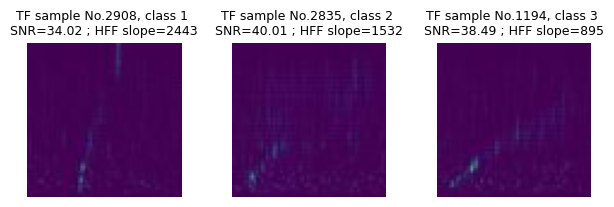

In [ ]:
# ------> Check: Plot one random image per class

RandInd1 = np.random.choice(len(images_c1))
RandInd2 = np.random.choice(len(images_c2))
RandInd3 = np.random.choice(len(images_c3))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7.5, 2))

img = Image.fromarray(images_c1[RandInd1])
ax1.imshow(img)
ax1.set_title('TF sample No.' + str(RandInd1) + ", class 1 \n" + "SNR=" + \
              "{:.2f}".format(logdata_c1[RandInd1][2]) + " ; HFF slope=" + \
              "{:.0f}".format(logdata_c1[RandInd1][3]), fontsize=9)
ax1.axis('off')

img = Image.fromarray(images_c2[RandInd2])
ax2.imshow(img)
ax2.set_title('TF sample No.' + str(RandInd2) + ", class 2 \n" + "SNR=" + \
              "{:.2f}".format(logdata_c2[RandInd2][2]) + " ; HFF slope=" + \
              "{:.0f}".format(logdata_c2[RandInd2][3]), fontsize=9)
ax2.axis('off')

img = Image.fromarray(images_c3[RandInd3])
ax3.imshow(img)
ax3.set_title('TF sample No.' + str(RandInd3) + ", class 3 \n" + "SNR=" + \
              "{:.2f}".format(logdata_c3[RandInd1][2]) + " ; HFF slope=" + \
              "{:.0f}".format(logdata_c3[RandInd1][3]), fontsize=9)
ax3.axis('off')

#plt.savefig(figs_dir + "sample_image_pixels_test.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# ------> Define vectors for target labels

# Remark: For a direct and easy application of functions and libraries,
# we relabel classes with 0, 1, and 2, maintaining the original ordinality.
# (In figures we keep original tags 1, 2, and 3).

y_0 = np.empty(len(images_c1)); y_0.fill(0)
y_0 = y_0.astype(int)

y_1 = np.empty(len(images_c2)); y_1.fill(1)
y_1 = y_1.astype(int)

y_2 = np.empty(len(images_c3)); y_2.fill(2)
y_2 = y_2.astype(int)

In [ ]:
# ------> Concatenate numpy arrays

X_data = np.concatenate((images_c1, images_c2, images_c3), axis=0)
y_data = np.concatenate((y_0, y_1, y_2), axis=0)

print(X_data.shape)
print(y_data.shape)

(9158, 64, 64, 3)
(9158,)


## 4) Split data: Train / Valid. / Test

In [ ]:
# Train (70%) and Test (30%)
train_set_x_orig, test_set_x_orig, train_set_y_orig, test_set_y_orig = train_test_split(X_data, y_data, test_size=0.3, random_state=43)

# Check dimensions

print("Images' dimensions:",  train_set_x_orig.shape, test_set_x_orig.shape)
print("")
print("Labels' dimensions:", train_set_y_orig.shape, test_set_y_orig.shape)

Images' dimensions: (6410, 64, 64, 3) (2748, 64, 64, 3)

Labels' dimensions: (6410,) (2748,)


In [ ]:
# Train (90%) and Validation (10%)
train_set_x_orig, vali_set_x_orig, train_set_y_orig, vali_set_y_orig = train_test_split(train_set_x_orig, train_set_y_orig, test_size=0.1, random_state=43)

# Check dimensions
print("Images' dimensions:",  train_set_x_orig.shape, vali_set_x_orig.shape)
print("")
print("Labels' dimensions:", train_set_y_orig.shape, vali_set_y_orig.shape)

Images' dimensions: (5769, 64, 64, 3) (641, 64, 64, 3)

Labels' dimensions: (5769,) (641,)


## 5) Features preparation

In [ ]:
# Target labels' unique values
classes = np.unique(test_set_y_orig)
print(classes)

[0 1 2]


In [ ]:
# Reshape arrays for target labels
train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
print(train_set_y_orig.shape)

vali_set_y_orig = vali_set_y_orig.reshape((1, vali_set_y_orig.shape[0]))
print(vali_set_y_orig.shape)

test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
print(test_set_y_orig.shape)

(1, 5769)
(1, 641)
(1, 2748)


In [ ]:
# Normalize image vectors
X_train = train_set_x_orig/255
X_vali = vali_set_x_orig/255
X_test  = test_set_x_orig/255

In [ ]:
# Convert training and test labels to one-hot matrices
y_train = convert_to_one_hot(train_set_y_orig, classes.shape[0]).T
y_vali = convert_to_one_hot(vali_set_y_orig, classes.shape[0]).T
y_test = convert_to_one_hot(test_set_y_orig, classes.shape[0]).T

In [ ]:
# Some checks

print ("No. of training samples = " + str(X_train.shape[0]))
print ("No. of validations samples = " + str(X_vali.shape[0]))
print ("No. of test samples = " + str(X_test.shape[0]))

print("")

# Note channels are last dimensions for images
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print("")
print ("X_vali shape: " + str(X_vali.shape))
print ("y_vali shape: " + str(y_vali.shape))
print("")
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

No. of training samples = 5769
No. of validations samples = 641
No. of test samples = 2748

X_train shape: (5769, 64, 64, 3)
y_train shape: (5769, 3)

X_vali shape: (641, 64, 64, 3)
y_vali shape: (641, 3)

X_test shape: (2748, 64, 64, 3)
y_test shape: (2748, 3)


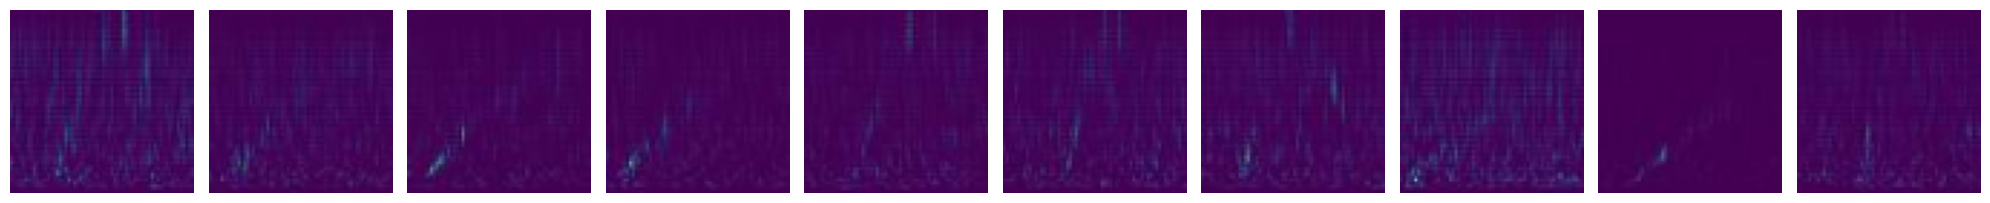

[0 1 1 1 0 0 0 2 2 0]


In [ ]:
# More visual checks for train set: images and labels
plotImages(X_train, train_set_y_orig)

## 6) ResNet50 architecture

**1st STEP: DEFINE IDENTITY BLOCK**

In [ ]:
def identity_block(X, f, filters, stage, block):

  '''
  Implementation of identity

  Arguments:
  X -       input tensor to the block of shape (m, n_H_prev, n_W_prev, n_C_prev)
  f -       defines shape of filter in the middle layer of the main path
  filters - list of integers, defining the number of filters in each layer of the main path
  stage -   defines the block position in the network
  block -   used for naming convention

  Returns:
  X - output is a tensor of shape (n_H, n_W, n_C) which matches (m, n_H_prev, n_W_prev, n_C_prev)
  '''

  # defining base name for block
  conv_base_name = 'res' + str(stage) + block + '_'
  bn_base_name = 'bn' + str(stage) + block + '_'

  # retrieve number of filters in each layer of main path
  # NOTE: f3 must be equal to n_C. That way dimensions of the third component will match the dimension of original input to identity block
  f1, f2, f3 = filters

  # Batch normalization must be performed on the 'channels' axis for input. It is 3, for our case
  bn_axis = 3

  # save input for "addition" to last layer output; step in skip-connection
  X_skip_connection = X

  # ----------------------------------------------------------------------
  # Building layers/component of identity block using Keras functional API

  # First component/layer of main path
  X = Conv2D(filters= f1, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'first_component')(X)
  X = Activation('relu')(X)

  # Second component/layer of main path
  X = Conv2D(filters= f2, kernel_size = (f,f), strides = (1,1), padding='same', name=conv_base_name+'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'second_component')(X)
  X = Activation('relu')(X)

  # Third component/layer of main path
  X = Conv2D(filters= f3, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'third_component')(X)

  # "Addition step" - skip-connection value merges with main path
  # NOTE: both values have same dimensions at this point, so no operation is required to match dimensions
  X = Add()([X, X_skip_connection])
  X = Activation('relu')(X)

  return X

**2nd STEP: DEFINE CONVOLUTION BLOCK**

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in above figure

    Arguments:
    X -       input tensor to the block of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -       defines shape of filter in the middle layer of the main path
    filters - list of integers, defining the number of filters in each layer of the main path
    stage -   defines the block position in the network
    block -   used for naming convention
    s -       specifies the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining base name for block
    conv_base_name = 'res' + str(stage) + block + '_'
    bn_base_name = 'bn' + str(stage) + block + '_'

    # retrieve number of filters in each layer of main path
    f1, f2, f3 = filters

    # Batch normalization must be performed on the 'channels' axis for input. It is 3, for our case
    bn_axis = 3

    # save input for "addition" to last layer output; step in skip-connection
    X_skip_connection = X

    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(f1, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'first_component')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(f2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_base_name + 'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'second_component')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(f3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_base_name + 'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'third_component')(X)

    ##### Convolve skip-connection value to match its dimensions to third layer output's dimensions ####
    X_skip_connection = Conv2D(f3, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'merge', kernel_initializer = glorot_uniform(seed=0))(X_skip_connection)
    X_skip_connection = BatchNormalization(axis = 3, name = bn_base_name + 'merge')(X_skip_connection)

    # "Addition step"
    # NOTE: both values have same dimensions at this point
    X = Add()([X, X_skip_connection])
    X = Activation('relu')(X)

    return X

**3rd STEP: JOIN TOGETHER STACKS, RESNET50**

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Arguments:
    input_shape - shape of the images of the dataset
    classes - number of classes

    Returns:
    model - a Model() instance in Keras

    """

    # plug in input_shape to define the input tensor
    X_input = Input(input_shape)

    # Zero-Padding : pads the input with a pad of (3,3)
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv_1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # NOTE: dimensions of filters that are passed to identity block are such that final layer output
    # in identity block mathces the original input to the block
    # blocks in each stage are alphabetically sequenced

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

## 7) Training and validation

### 7.1) Single learning process

In [ ]:
# Folder location to save models
models_dir = '/content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Models/Single_learning/'
print("Models are saved in the folder:", models_dir)

Models are saved in the folder: /content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Models/Single_learning/


In [ ]:
# Define model
model = ResNet50(input_shape = (64, 64, 3), classes = 3)

In [ ]:
# Learning settings
lrate = 0.0005        # Learning rate
batch = 50            # Batch size
num_epochs = 10       # No. of epochs

In [ ]:
# Set early stopping and model checkpoint
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(models_dir + '/bestmodel_learning_temp.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Set the optimizer
optimizer = keras.optimizers.Adam(learning_rate=lrate)

# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
# print(model.summary())

In [ ]:
# Train and validate model

#history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch, validation_data = (X_vali, y_vali), callbacks=[es, mc])
history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch, validation_data = (X_vali, y_vali), callbacks=[mc])

In [ ]:
# Load the best model from the learning
model = load_model(models_dir + '/bestmodel_learning_temp.keras')

# Define class names
class_names = ['Class 1','Class 2', 'Class 3']

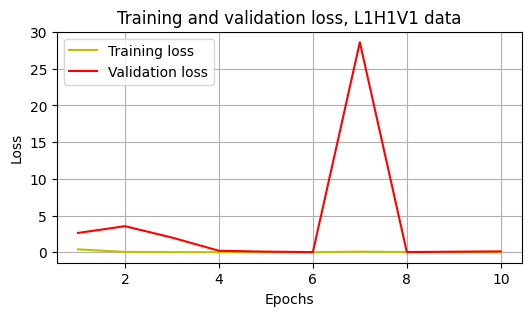

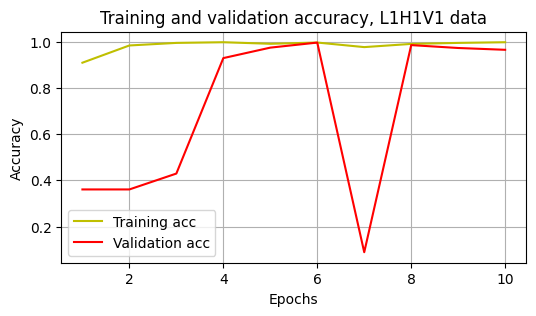

In [ ]:
# ------> Plot loss and accuracy during the training and validation

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Epochs
epochs = range(1, len(loss) + 1)

# Plot the curves

plt.figure(figsize=(6,3))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss, ' + ifo_conf + ' data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
#plt.savefig(figs_dir + "train-vali_loss_" + ifo_conf + ".pdf", format="pdf")
plt.show()

print("")

plt.figure(figsize=(6,3))
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy, ' + ifo_conf + ' data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
#plt.savefig(figs_dir + "train-vali_accu_" + ifo_conf + ".pdf", format="pdf")
plt.show()

In [ ]:
# ------> Final test
predictions = model.evaluate(X_test, y_test)
print("Test loss = " + str(predictions[0]))
print("Test accuracy = " + str(predictions[1]))

In [ ]:
# ------> Save current Deep Learning Model

model.save(models_dir + "ResNet50_" + ifo_conf + ".keras")

### 7.2) GridSearch with k-fold CV

In [ ]:
# Folder location to save model results
models_dir = '/content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Models/GridSearchCV/'
print("Models are saved in the folder:", models_dir)

Models are saved in the folder: /content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Models/GridSearchCV/


In [ ]:
# No. of iterations in k-fold CV

k_fold = 5

In [ ]:
# Initial hyperparameters

lrate = 0.0005     # Learning rate
batch = 50         # Batch size
num_epochs = 30    # No. of epochs

#### Tuning 1: Optimizer

In [ ]:
# Define the model with KerasClassifier

def create_model():
 model = ResNet50(input_shape = (64, 64, 3), classes = 3)
 model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
 return model

model = KerasClassifier(model=create_model, epochs = num_epochs, batch_size = batch, verbose=0)

In [ ]:
# Define the grid search parameters
optimizer = ['SGD(learning_rate=lrate)', 'RMSprop(learning_rate=lrate)', 'Adagrad(learning_rate=lrate)',
             'Adadelta(learning_rate=lrate)', 'Adam(learning_rate=lrate)', 'Adamax(learning_rate=lrate)', 'Nadam(learning_rate=lrate)']

param_grid = dict(optimizer=optimizer)

In [ ]:
# Run GridSearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=k_fold, verbose=10)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5; 1/7] START optimizer=SGD(learning_rate=lrate)..........................
[CV 1/5; 1/7] END optimizer=SGD(learning_rate=lrate);, score=0.996 total time= 2.1min
[CV 2/5; 1/7] START optimizer=SGD(learning_rate=lrate)..........................
[CV 2/5; 1/7] END optimizer=SGD(learning_rate=lrate);, score=0.997 total time= 1.9min
[CV 3/5; 1/7] START optimizer=SGD(learning_rate=lrate)..........................
[CV 3/5; 1/7] END optimizer=SGD(learning_rate=lrate);, score=0.996 total time= 1.9min
[CV 4/5; 1/7] START optimizer=SGD(learning_rate=lrate)..........................
[CV 4/5; 1/7] END optimizer=SGD(learning_rate=lrate);, score=0.993 total time= 2.0min
[CV 5/5; 1/7] START optimizer=SGD(learning_rate=lrate)..........................
[CV 5/5; 1/7] END optimizer=SGD(learning_rate=lrate);, score=0.990 total time= 2.0min
[CV 1/5; 2/7] START optimizer=RMSprop(learning_rate=lrate)......................
[CV 1/5; 2/7] END optimi

In [ ]:
# Summarize results
best_config = "Best: %f accuracy using %s" % (grid_result.best_score_, grid_result.best_params_)
print(best_config)

means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("mean accuracy: %f (stdev: %f) with: %r" % (mean, stdev, param))

Best: 0.994280 accuracy using {'optimizer': 'RMSprop(learning_rate=lrate)'}
mean accuracy: 0.994279 (stdev: 0.002236) with: {'optimizer': 'SGD(learning_rate=lrate)'}
mean accuracy: 0.994280 (stdev: 0.000884) with: {'optimizer': 'RMSprop(learning_rate=lrate)'}
mean accuracy: 0.991333 (stdev: 0.004138) with: {'optimizer': 'Adagrad(learning_rate=lrate)'}
mean accuracy: 0.992199 (stdev: 0.002849) with: {'optimizer': 'Adadelta(learning_rate=lrate)'}
mean accuracy: 0.988734 (stdev: 0.008560) with: {'optimizer': 'Adam(learning_rate=lrate)'}
mean accuracy: 0.951992 (stdev: 0.084321) with: {'optimizer': 'Adamax(learning_rate=lrate)'}
mean accuracy: 0.991853 (stdev: 0.004159) with: {'optimizer': 'Nadam(learning_rate=lrate)'}


In [ ]:
# Save results
with open(models_dir + "GridSearchCV_tuning_1_bestconfig.txt", "w") as text_file:
    text_file.write(best_config)
with open(models_dir + 'GridSearchCV_tuning_1.pkl', 'wb') as f:
    pickle.dump(grid_result.cv_results_, f)

In [ ]:
# Open results
with open(models_dir + 'GridSearchCV_tuning_1.pkl', 'rb') as f:
  tuning1_dict = pickle.load(f)

tuning1_dict

#### Tuning 2: Batch size, No. of epochs

In [ ]:
# Read and print best config of previous tuning
file = open(models_dir + "GridSearchCV_tuning_1_bestconfig.txt", 'r')
first_line = file.readline()
print(first_line)

Best: 0.994280 accuracy using {'optimizer': 'RMSprop(learning_rate=lrate)'}


In [ ]:
# Define the model with KerasClassifier
# Important remark: Ensure that you are using the best optimizer of tunning 1

def create_model():
 model = ResNet50(input_shape = (64, 64, 3), classes = 3)
 optimizer = keras.optimizers.RMSprop(learning_rate=lrate)
 model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

model = KerasClassifier(model=create_model, verbose=0)

In [ ]:
# Define the grid search parameters
batch = [25, 50, 75, 100]
num_epochs = [20, 30, 40]
param_grid = dict(batch_size=batch, epochs=num_epochs)

In [ ]:
# Run GridSearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=k_fold, verbose=10)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START batch_size=25, epochs=20...................................
[CV 1/5; 1/12] END ....batch_size=25, epochs=20;, score=0.995 total time= 2.5min
[CV 2/5; 1/12] START batch_size=25, epochs=20...................................
[CV 2/5; 1/12] END ....batch_size=25, epochs=20;, score=0.997 total time= 2.5min
[CV 3/5; 1/12] START batch_size=25, epochs=20...................................
[CV 3/5; 1/12] END ....batch_size=25, epochs=20;, score=0.997 total time= 2.4min
[CV 4/5; 1/12] START batch_size=25, epochs=20...................................
[CV 4/5; 1/12] END ....batch_size=25, epochs=20;, score=0.990 total time= 2.4min
[CV 5/5; 1/12] START batch_size=25, epochs=20...................................
[CV 5/5; 1/12] END ....batch_size=25, epochs=20;, score=0.979 total time= 2.4min
[CV 1/5; 2/12] START batch_size=25, epochs=30...................................
[CV 1/5; 2/12] END ....batch_size=25, epochs=30;

In [ ]:
# Summarize results
best_config = "Best: %f accuracy using %s" % (grid_result.best_score_, grid_result.best_params_)
print(best_config)

means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("mean accuracy: %f (stdev: %f) with: %r" % (mean, stdev, param))

Best: 0.996013 accuracy using {'batch_size': 75, 'epochs': 40}
mean accuracy: 0.991504 (stdev: 0.006728) with: {'batch_size': 25, 'epochs': 20}
mean accuracy: 0.992027 (stdev: 0.006186) with: {'batch_size': 25, 'epochs': 30}
mean accuracy: 0.995666 (stdev: 0.001343) with: {'batch_size': 25, 'epochs': 40}
mean accuracy: 0.990467 (stdev: 0.004777) with: {'batch_size': 50, 'epochs': 20}
mean accuracy: 0.993934 (stdev: 0.005774) with: {'batch_size': 50, 'epochs': 30}
mean accuracy: 0.995320 (stdev: 0.003032) with: {'batch_size': 50, 'epochs': 40}
mean accuracy: 0.990466 (stdev: 0.003104) with: {'batch_size': 75, 'epochs': 20}
mean accuracy: 0.995320 (stdev: 0.001175) with: {'batch_size': 75, 'epochs': 30}
mean accuracy: 0.996013 (stdev: 0.001511) with: {'batch_size': 75, 'epochs': 40}
mean accuracy: 0.888488 (stdev: 0.157446) with: {'batch_size': 100, 'epochs': 20}
mean accuracy: 0.976602 (stdev: 0.033895) with: {'batch_size': 100, 'epochs': 30}
mean accuracy: 0.990986 (stdev: 0.005414) wi

In [ ]:
# Save results
with open(models_dir + "GridSearchCV_tuning_2_bestconfig.txt", "w") as text_file:
    text_file.write(best_config)
with open(models_dir + 'GridSearchCV_tuning_2.pkl', 'wb') as f:
    pickle.dump(grid_result.cv_results_, f)

In [ ]:
# Open results
with open(models_dir + 'GridSearchCV_tuning_2.pkl', 'rb') as f:
  tuning2_dict = pickle.load(f)

tuning2_dict

#### Tuning 3: Learning rate and momentum

In [ ]:
# Read and print best config of previous tuning
file = open(models_dir + "GridSearchCV_tuning_2_bestconfig.txt", 'r')
first_line = file.readline()
print(first_line)

Best: 0.996013 accuracy using {'batch_size': 75, 'epochs': 40}


In [ ]:
# Set the best batch size and no. of epochs
# Important remark: Ensure that you are using the best optimizer of tunning 2

num_epochs = 40
batch = 75

In [ ]:
# Define the model with KerasClassifier
# Important remark: Ensure that you are using the best optimizer of tunning 1

def create_model():
 model = ResNet50(input_shape = (64, 64, 3), classes = 3)
 optimizer = keras.optimizers.RMSprop()
 model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

model = KerasClassifier(model=create_model, epochs=num_epochs, batch_size=batch, verbose=0)

In [ ]:
# Define the grid search parameters
learn_rate = [0.0005, 0.001, 0.01, 0.1]
momentum = [0.0, 0.2, 0.4, 0.6]

param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)

In [ ]:
# Run GridSearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=k_fold, verbose=10)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START optimizer__learning_rate=0.0005, optimizer__momentum=0.0...
[CV 1/5; 1/16] END optimizer__learning_rate=0.0005, optimizer__momentum=0.0;, score=0.996 total time= 1.9min
[CV 2/5; 1/16] START optimizer__learning_rate=0.0005, optimizer__momentum=0.0...
[CV 2/5; 1/16] END optimizer__learning_rate=0.0005, optimizer__momentum=0.0;, score=0.997 total time= 1.7min
[CV 3/5; 1/16] START optimizer__learning_rate=0.0005, optimizer__momentum=0.0...
[CV 3/5; 1/16] END optimizer__learning_rate=0.0005, optimizer__momentum=0.0;, score=0.960 total time= 1.7min
[CV 4/5; 1/16] START optimizer__learning_rate=0.0005, optimizer__momentum=0.0...
[CV 4/5; 1/16] END optimizer__learning_rate=0.0005, optimizer__momentum=0.0;, score=0.980 total time= 1.7min
[CV 5/5; 1/16] START optimizer__learning_rate=0.0005, optimizer__momentum=0.0...
[CV 5/5; 1/16] END optimizer__learning_rate=0.0005, optimizer__momentum=0.0;, score=0.999 total ti

In [ ]:
# Summarize results
best_config = "Best: %f accuracy using %s" % (grid_result.best_score_, grid_result.best_params_)
print(best_config)

means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("mean accuracy: %f (stdev: %f) with: %r" % (mean, stdev, param))

Best: 0.996533 accuracy using {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.6}
mean accuracy: 0.986308 (stdev: 0.014700) with: {'optimizer__learning_rate': 0.0005, 'optimizer__momentum': 0.0}
mean accuracy: 0.992200 (stdev: 0.004809) with: {'optimizer__learning_rate': 0.0005, 'optimizer__momentum': 0.2}
mean accuracy: 0.994974 (stdev: 0.002413) with: {'optimizer__learning_rate': 0.0005, 'optimizer__momentum': 0.4}
mean accuracy: 0.996187 (stdev: 0.001511) with: {'optimizer__learning_rate': 0.0005, 'optimizer__momentum': 0.6}
mean accuracy: 0.993587 (stdev: 0.001407) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.0}
mean accuracy: 0.992894 (stdev: 0.006112) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
mean accuracy: 0.993067 (stdev: 0.007124) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.4}
mean accuracy: 0.994800 (stdev: 0.002571) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
mean ac

In [ ]:
# Save results
with open(models_dir + "GridSearchCV_tuning_3_bestconfig.txt", "w") as text_file:
    text_file.write(best_config)
with open(models_dir + 'GridSearchCV_tuning_3.pkl', 'wb') as f:
    pickle.dump(grid_result.cv_results_, f)

In [ ]:
# Open results
with open(models_dir + 'GridSearchCV_tuning_3.pkl', 'rb') as f:
  tuning3_dict = pickle.load(f)

tuning3_dict

## 8) Training/test and model evaluation

### 8.1) Training/test

In [ ]:
# Folder location to save models
models_dir = '/content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Models/Best_training/'
print("Best model is saved in the folder:", models_dir)

Best model is saved in the folder: /content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Models/Best_training/


In [ ]:
# Define model
model = ResNet50(input_shape = (64, 64, 3), classes = 3)

In [ ]:
# Set best hyperparameters
# Important remark: Ensure that you are using results found in tunings

batch = 75          # Batch size
num_epochs = 40     # No. of epochs
lrate = 0.01        # Learning rate
mom = 0.6           # Momentum

In [ ]:
# Set early stopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Set model checkpoint callback
mc = ModelCheckpoint(models_dir + '/bestmodel_training.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Set the optimizer
# Important remark: Ensure that you are using results found in tunings
optimizer = keras.optimizers.RMSprop(learning_rate=lrate, momentum=mom)

# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
# print(model.summary())

In [ ]:
# Train and validate model

#history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch, validation_data = (X_vali, y_vali), callbacks=[es, mc])
history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch, validation_data = (X_vali, y_vali), callbacks=[mc])

Epoch 1/40
77/77 [==============================] - ETA: 0s - loss: 1.7288 - accuracy: 0.4938
Epoch 1: val_accuracy improved from -inf to 0.36037, saving model to /content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Models/Best_training/bestmodel_training.keras
77/77 [==============================] - 51s 199ms/step - loss: 1.7288 - accuracy: 0.4938 - val_loss: 859229.6250 - val_accuracy: 0.3604
Epoch 2/40
77/77 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.7532
Epoch 2: val_accuracy did not improve from 0.36037
77/77 [==============================] - 7s 92ms/step - loss: 0.5634 - accuracy: 0.7532 - val_loss: 537698.4375 - val_accuracy: 0.3604
Epoch 3/40
77/77 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8476
Epoch 3: val_accuracy did not improve from 0.36037
77/77 [==============================] - 8s 98ms/step - loss: 0.3607 - accuracy: 0.8476 - val_loss: 28393.4004 - val_accuracy: 0.3604
Epoch 4/40
77/77 [=========

In [ ]:
# Load the best model from the learning
model = load_model(models_dir + '/bestmodel_training.keras')

# Define class names
class_names = ['Class 1','Class 2', 'Class 3']

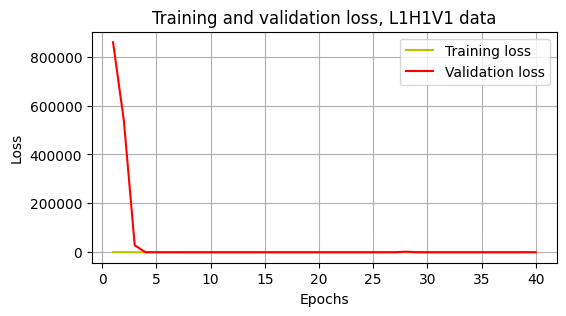

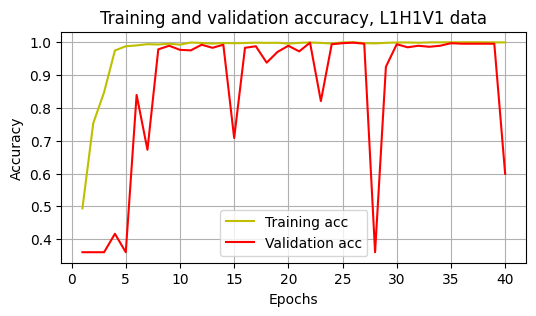

In [ ]:
# ------> Plot loss and accuracy during the training and validation

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Epochs
epochs = range(1, len(loss) + 1)

# Plot the curves

plt.figure(figsize=(6,3))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss, ' + ifo_conf + ' data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
#plt.savefig(figs_dir + "train-vali_loss_" + ifo_conf + ".pdf", format="pdf")
plt.show()

print("")

plt.figure(figsize=(6,3))
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy, ' + ifo_conf + ' data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
#plt.savefig(figs_dir + "train-vali_accu_" + ifo_conf + ".pdf", format="pdf")
plt.show()

In [ ]:
# ------> Final test

predictions = model.evaluate(X_test, y_test)
print("Test loss = " + str(predictions[0]))
print("Test accuracy = " + str(predictions[1]))

86/86 [==============================] - 5s 28ms/step - loss: 0.0304 - accuracy: 0.9942
Test loss = 0.03035786934196949
Test accuracy = 0.9941775798797607


### 8.2) Model evaluation

In [ ]:
# ------> Obtain prediccions of the model

predictions = model.predict(X_test)
print("Predictions dim:", predictions.shape)

predicted_labels = np.zeros(len(predictions))

for i in range(len(predictions)):
    predicted_labels[i] = int(np.argmax(predictions[i]))
print("Predicted labels dim:", predicted_labels.shape)

print("")
print("-----------------------")
print("For instance, two predictions:")
print("")
print("prediction: ", predictions[0])
print("predicted_label: ", predicted_labels[0])
print("")
print("prediction: ", predictions[4])
print("predicted_label: ", predicted_labels[4])

86/86 [==============================] - 4s 20ms/step
Predictions dim: (2748, 3)
Predicted labels dim: (2748,)

-----------------------
For instance, two predictions:

prediction:  [1.0242138e-16 4.2339499e-13 1.0000000e+00]
predicted_label:  2.0

prediction:  [1.0000000e+00 6.1939285e-09 4.9445088e-12]
predicted_label:  0.0


In [ ]:
# ------> Compute the confusion matrix

# Remark: Columns --> Prediction labels
#         Rows    --> Real labels

y_test_orig = deconvert_from_one_hot(y_test)

y_test_orig = y_test_orig.astype(int)
predicted_labes = predicted_labels.astype(int)

cnf_matrix = tf.math.confusion_matrix(y_test_orig, predicted_labels, num_classes=None)
print(cnf_matrix)

tf.Tensor(
[[930   1   0]
 [  2 907   0]
 [  2  11 895]], shape=(3, 3), dtype=int32)


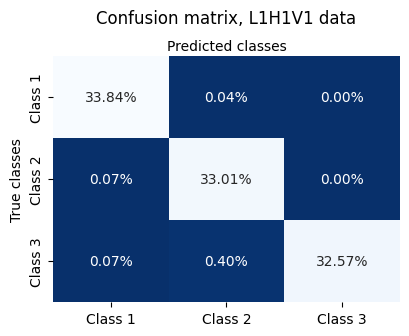

In [ ]:
import seaborn as sns

class_names = ['Class 1','Class 2', 'Class 3']

plt.rcParams["figure.figsize"] = [4.0, 3.0]

fig, ax = plt.subplots()
sns.heatmap(cnf_matrix/np.sum(cnf_matrix), annot = True, cmap = 'Blues_r', fmt='.2%', cbar=False)

ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix, ' + ifo_conf + ' data', y = 1.1)
plt.ylabel('True classes')
plt.xlabel('Predicted classes')

tick_marks = np.arange(0.5, len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#plt.savefig(figs_dir + "confu-matrix_" + ifo_conf + ".pdf", format="pdf")

plt.show()

In [ ]:
# ------> Save current Deep Learning Model

model.save(models_dir + "ResNet50_" + ifo_conf + ".keras")

# II. Test with GenRel waveforms

## 1) Load trained model

In [ ]:
# ------> Load Best ResNet50 Model

models_dir = '/content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Models/Best_training/'

model = load_model(models_dir + "ResNet50_L1H1V1.keras")

In [ ]:
# Define class names

class_names = ['Class 1','Class 2', 'Class 3']

## 2) Input parameters

In [ ]:
# Interferometer combination
# -------------------------------------------------------------------------------------
detectors = ["V1"]    # Options (combinations included): "L1", "H1", "V1"
# -------------------------------------------------------------------------------------

# Merge information about detectors
ifo_conf = ''.join(detectors)

# CCSNe source distance in Kpc (only for general relativistic waveforms)
# -------------------------------------------------------------------------------------
distance = 10    # Options: 1, 5, 10 (for now)
# -------------------------------------------------------------------------------------

## 3) Read files

In [ ]:
# ------> Specify folder location

data_dir = '/content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Datasets/GenRelWf/Distance_' + str(distance) + 'Kpc/'

print("TF datasets are located at:", data_dir)
print("")

TF datasets are located at: /content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Datasets/NumWf/Distance_10Kpc/



In [ ]:
# Initialize list for image data
image_ifos = []

# Initialize list for log data
logdata_ifos = []

# Initialize images count
Num_images = 0

# Remark: each element of image_ifos list contains
# data from each selected interferometric detector

# ------> Loop: Interferometric detectors

for ifo in detectors:

    os.chdir(data_dir)

    print("DATA from detector:", ifo)
    print("======================== ")

    # Initialize images count for each segment
    Num_images_seg = 0

    # Initialize dictionary for images
    class_images = {}

    # Initialize dictionary for log data
    class_logdata = {}

    # ------> Loop: Class of the images

    for folder in glob.glob(ifo + "*"):

        #print("FOLDER:", folder)

        if "_TF_samples" in folder:

          print("SCANNING", folder, "FOLDER")
          print("------------------------------------------")

          os.chdir(data_dir + folder + "/")

          for subfolder in glob.glob("*"):

            subfolder_path = data_dir + folder + "/" + subfolder + "/"
            #print(subfolder_path)

            os.chdir(subfolder_path)

            print("   ******  SCANNING", subfolder, "SUBFOLDER")
            print("")

            #print(subfolder_path)

            class_images, class_logdata, Num_images_ifo = load_imagedata(subfolder_path, class_images, class_logdata, 1)
            Num_images_seg = Num_images_seg + Num_images_ifo

    Num_images = Num_images + Num_images_seg

    image_ifos.append(class_images)
    logdata_ifos.append(class_logdata)

    print("Loaded images: ", Num_images_seg)
    print("")

print("Total number of loaded images: ", Num_images)

DATA from detector: V1
SCANNING V1_TF_samples_c1 FOLDER
------------------------------------------
   ******  SCANNING Andresen_2019 SUBFOLDER

SCANNING V1_TF_samples_c2 FOLDER
------------------------------------------
   ******  SCANNING Morozova_2018 SUBFOLDER

SCANNING V1_TF_samples_c3 FOLDER
------------------------------------------
   ******  SCANNING Cerda-Duran_2013 SUBFOLDER

Loaded images:  300

Total number of loaded images:  300


## 4) Images preparation

In [ ]:
# ------> For each class, join together all image samples

# Initialize lists for each class
images_label1 = []
images_label2 = []
images_label3 = []

# Stacks all arrays of image_ifos[i]["class c"]
# (with i=1,...,N_ifos, c={1,2,3}), as a single array
for i in range(len(image_ifos)):

  images_label1_seg = np.stack(image_ifos[i]["class 1"])
  images_label2_seg = np.stack(image_ifos[i]["class 2"])
  images_label3_seg = np.stack(image_ifos[i]["class 3"])

  images_label1.append(images_label1_seg)
  images_label2.append(images_label2_seg)
  images_label3.append(images_label3_seg)

# For each class, concatenate numpy arrays
images_c1 = np.concatenate(images_label1, axis=0)
images_c2 = np.concatenate(images_label2, axis=0)
images_c3 = np.concatenate(images_label3, axis=0)

In [ ]:
# ------> Check dimensions

print("Class 1 images:", images_c1.shape)
print("Class 2 images:", images_c2.shape)
print("Class 3 images:", images_c3.shape)

Class 1 images: (100, 64, 64, 3)
Class 2 images: (100, 64, 64, 3)
Class 3 images: (100, 64, 64, 3)


In [ ]:
# ------> For each class, join together all log data arrays

# Initialize lists for each class
logdata_label1 = []
logdata_label2 = []
logdata_label3 = []

# Stacks all arrays of image_ifos[i]["class c"]
# (with i=1,...,N_ifos, c={1,2,3}), as a single array
for i in range(len(image_ifos)):

  logdata_label1_seg = np.stack(logdata_ifos[i]["class 1"])
  logdata_label2_seg = np.stack(logdata_ifos[i]["class 2"])
  logdata_label3_seg = np.stack(logdata_ifos[i]["class 3"])

  logdata_label1.append(logdata_label1_seg)
  logdata_label2.append(logdata_label2_seg)
  logdata_label3.append(logdata_label3_seg)

# For each class, concatenate numpy arrays
logdata_c1 = np.concatenate(logdata_label1, axis=0)
logdata_c2 = np.concatenate(logdata_label2, axis=0)
logdata_c3 = np.concatenate(logdata_label3, axis=0)


In [ ]:
# ------> Check dimensions

print("Class 1 images:", logdata_c1.shape)
print("Class 2 images:", logdata_c2.shape)
print("Class 3 images:", logdata_c3.shape)

# Reminder - Columns of log data arrays (Gen. Rel. waveform):
# Injection time [s], jitter [s], Waveform SNR, HFF slope, Waveform duration [s]

Class 1 images: (511, 4)
Class 2 images: (511, 4)
Class 3 images: (511, 4)


In [ ]:
figs_dir = '/content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Figures/'
print("Figures will be saved in the folder:", figs_dir)

Figures will be saved in the folder: /content/drive/MyDrive/Colab Notebooks/GitHub/CCSNeHFGW_ResNetClass/Figures/


(-0.5, 63.5, 63.5, -0.5)

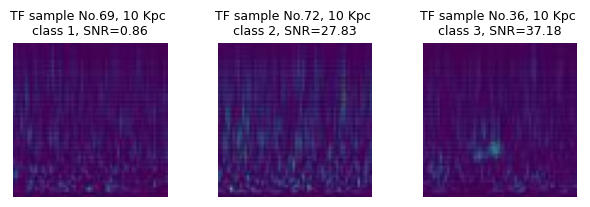

In [ ]:
# ------> Check: Plot one random image per class

RandInd1 = np.random.choice(len(images_c1))
RandInd2 = np.random.choice(len(images_c2))
RandInd3 = np.random.choice(len(images_c3))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7.5, 2))

img = Image.fromarray(images_c1[RandInd1])
ax1.imshow(img)
ax1.set_title('TF sample No.' + str(RandInd1) + ", " + str(distance) + " Kpc \n" + "class 1, " + "SNR=" + \
              "{:.2f}".format(logdata_c1[RandInd1][2]), fontsize=9)
ax1.axis('off')

img = Image.fromarray(images_c2[RandInd2])
ax2.imshow(img)
ax2.set_title('TF sample No.' + str(RandInd2) + ", " + str(distance) + " Kpc \n" + "class 2, " + "SNR=" + \
              "{:.2f}".format(logdata_c2[RandInd2][2]), fontsize=9)
ax2.axis('off')

img = Image.fromarray(images_c3[RandInd3])
ax3.imshow(img)
ax3.set_title('TF sample No.' + str(RandInd3) + ", " + str(distance) + " Kpc \n" + "class 3, " + "SNR=" + \
              "{:.2f}".format(logdata_c3[RandInd1][2]), fontsize=9)
ax3.axis('off')

#samples_figs_path = figs_dir + "sample_image_pixels_" + ifo_conf + "_GenRel_" + str(distance) + "Kpc.pdf"
#plt.savefig(samples_figs_path, format="pdf")

In [ ]:
# ------> Define vectors for target labels

# Remark: For a direct and easy application of functions and libraries,
# we relabel classes with 0, 1, and 2, maintaining the original ordinality.
# (In figures we keep original tags 1, 2, and 3).

y_0 = np.empty(len(images_c1)); y_0.fill(0)
y_0 = y_0.astype(int)

y_1 = np.empty(len(images_c2)); y_1.fill(1)
y_1 = y_1.astype(int)

y_2 = np.empty(len(images_c3)); y_2.fill(2)
y_2 = y_2.astype(int)

In [ ]:
# ------> Concatenate numpy arrays

X_data = np.concatenate((images_c1, images_c2, images_c3), axis=0)
y_data = np.concatenate((y_0, y_1, y_2), axis=0)

print(X_data.shape)
print(y_data.shape)

(300, 64, 64, 3)
(300,)


## 5) SNR populations

In [ ]:
# Save arrays in a numpy file

wf_SNR_c1 = np.transpose(logdata_c1)[2]
np.save(figs_dir + ifo_conf + "_snr_c1_" + str(distance) + "Kpc", wf_SNR_c1)

wf_SNR_c2 = np.transpose(logdata_c2)[2]
np.save(figs_dir + ifo_conf + "_snr_c2_" + str(distance) + "Kpc", wf_SNR_c2)

wf_SNR_c3 = np.transpose(logdata_c3)[2]
np.save(figs_dir + ifo_conf + "_snr_c3_" + str(distance) + "Kpc", wf_SNR_c3)

In [ ]:
# ------> Signal-to-noise ratio histograms

# Remark: Run this cell only if you have previously saved the
#         SNR values for the three distances (1Kpc, 5Kpc, 10Kpc)
#         and the three class samples: Andresen, Morozova, Cerda-Duran.

# Load saved numpy arrays for the three distances

# Class 1 model
wf_SNR_c1_d1 = np.load(figs_dir + ifo_conf + "_snr_c1_1Kpc.npy")
wf_SNR_c1_d2 = np.load(figs_dir + ifo_conf + "_snr_c1_5Kpc.npy")
wf_SNR_c1_d3 = np.load(figs_dir + ifo_conf + "_snr_c1_10Kpc.npy")

# Class 2 model
wf_SNR_c2_d1 = np.load(figs_dir + ifo_conf + "_snr_c2_1Kpc.npy")
wf_SNR_c2_d2 = np.load(figs_dir + ifo_conf + "_snr_c2_5Kpc.npy")
wf_SNR_c2_d3 = np.load(figs_dir + ifo_conf + "_snr_c2_10Kpc.npy")

# Class 3 model
wf_SNR_c3_d1 = np.load(figs_dir + ifo_conf + "_snr_c3_1Kpc.npy")
wf_SNR_c3_d2 = np.load(figs_dir + ifo_conf + "_snr_c3_5Kpc.npy")
wf_SNR_c3_d3 = np.load(figs_dir + ifo_conf + "_snr_c3_10Kpc.npy")

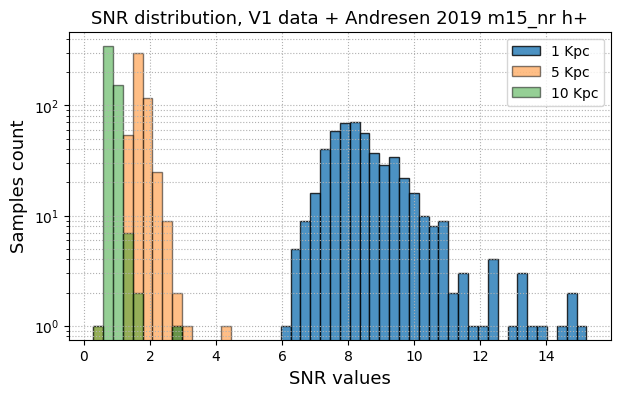

49196

<Figure size 640x480 with 0 Axes>

In [ ]:
# -------------------- Class 1

plt.figure(1, figsize=(7,4))

bins = np.histogram(np.hstack((wf_SNR_c1_d1,wf_SNR_c1_d2,wf_SNR_c1_d3)), bins=50)[1]

plt.hist(wf_SNR_c1_d1, bins, alpha=.8, edgecolor='black', label='1 Kpc')
plt.hist(wf_SNR_c1_d2, bins, alpha=.5, edgecolor='black', label='5 Kpc')
plt.hist(wf_SNR_c1_d3, bins, alpha=.5, edgecolor='black', label='10 Kpc')

plt.title("SNR distribution, " + ifo_conf + " data + Andresen 2019 m15_nr h+", fontsize=13)
plt.ylabel("Samples count", fontsize=13)
plt.xlabel("SNR values", fontsize=13)

plt.yscale('log')
plt.grid(which='both', linestyle=':')
plt.legend()

#plt.savefig(figs_dir + ifo_conf + "_distribution_snr_c1" + "_GRWf.pdf", format="pdf")

plt.show()
plt.figure(1).clear()
gc.collect()

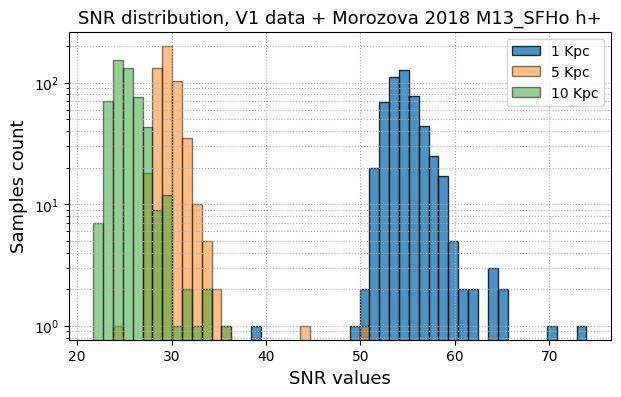

<Figure size 640x480 with 0 Axes>

In [ ]:
# -------------------- Class 2

plt.figure(1, figsize=(7,4))

bins = np.histogram(np.hstack((wf_SNR_c2_d1,wf_SNR_c2_d2,wf_SNR_c2_d3)), bins=50)[1]

plt.hist(wf_SNR_c2_d1, bins, alpha=.8, edgecolor='black', label='1 Kpc')
plt.hist(wf_SNR_c2_d2, bins, alpha=.5, edgecolor='black', label='5 Kpc')
plt.hist(wf_SNR_c2_d3, bins, alpha=.5, edgecolor='black', label='10 Kpc')

plt.title("SNR distribution, " + ifo_conf + " data + Morozova 2018 M13_SFHo h+", fontsize=13)
plt.ylabel("Samples count", fontsize=13)
plt.xlabel("SNR values", fontsize=13)

plt.yscale('log')
plt.grid(which='both', linestyle=':')
plt.legend()

#plt.savefig(figs_dir + ifo_conf + "_distribution_snr_c2" + "_GRWf.pdf", format="pdf")

plt.show()
plt.figure(1).clear()

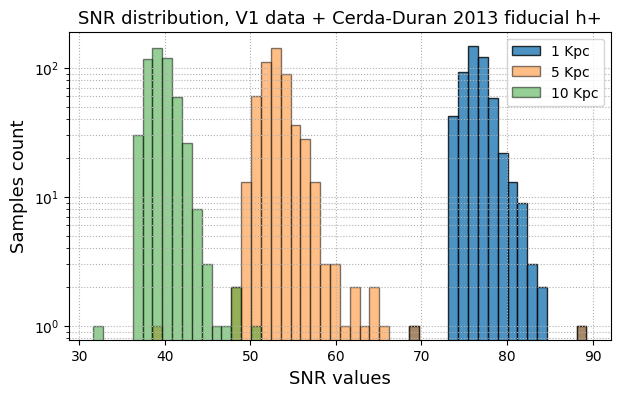

<Figure size 640x480 with 0 Axes>

In [ ]:
# -------------------- Class 3

plt.figure(1, figsize=(7,4))

bins = np.histogram(np.hstack((wf_SNR_c3_d1,wf_SNR_c3_d2,wf_SNR_c3_d3)), bins=50)[1]

plt.hist(wf_SNR_c3_d1, bins, alpha=.8, edgecolor='black', label='1 Kpc')
plt.hist(wf_SNR_c3_d2, bins, alpha=.5, edgecolor='black', label='5 Kpc')
plt.hist(wf_SNR_c3_d3, bins, alpha=.5, edgecolor='black', label='10 Kpc')

plt.title("SNR distribution, " + ifo_conf + " data + Cerda-Duran 2013 fiducial h+", fontsize=13)
plt.ylabel("Samples count", fontsize=13)
plt.xlabel("SNR values", fontsize=13)

plt.yscale('log')
plt.grid(which='both', linestyle=':')
plt.legend()

#plt.savefig(figs_dir + ifo_conf + "_distribution_snr_c3" + "_GRWf.pdf", format="pdf")

plt.show()
plt.figure(1).clear()

## 6) Features preparation

In [ ]:
# Target labels' unique values
classes = np.unique(y_data)
print(classes)

[0 1 2]


In [ ]:
# Shuffle arrays
X_data, y_data = shuffle(X_data, y_data, random_state=0)

# Check dimensions
print(X_data.shape, y_data.shape)

(300, 64, 64, 3) (300,)


In [ ]:
# Reshape arrays for target labels
y_data_orig = y_data.reshape((1, y_data.shape[0]))
print(y_data_orig.shape)

(1, 300)


In [ ]:
# Normalize image vectors
X_data = X_data/255

In [ ]:
# Convert training and test labels to one-hot matrices
y_data = convert_to_one_hot(y_data_orig, classes.shape[0]).T

In [ ]:
# Some checks

print ("No. of samples = " + str(X_data.shape[0]))

print("")

# Notice that channels are last dimensions for images
print ("X_data shape: " + str(X_data.shape))
print ("y_data shape: " + str(y_data.shape))

No. of samples = 300

X_data shape: (300, 64, 64, 3)
y_data shape: (300, 3)


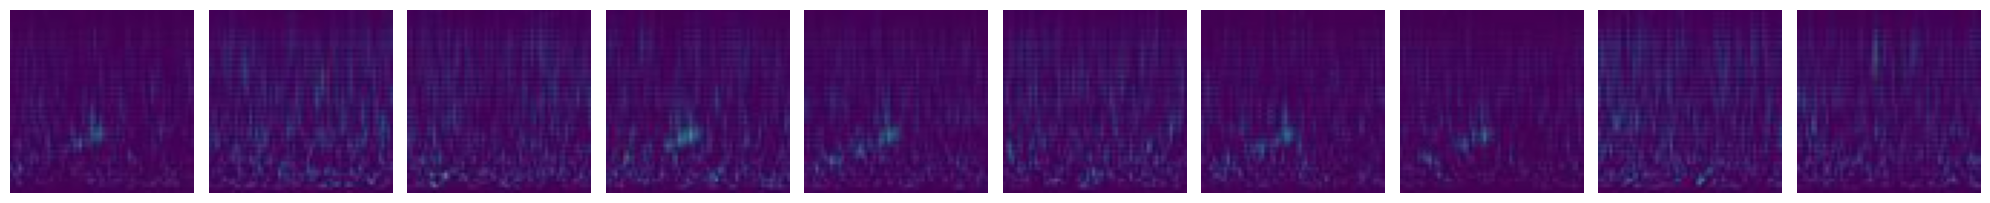

[2 1 0 2 2 1 2 2 0 1]


In [ ]:
# More visual checks: images and labels
plotImages(X_data, y_data_orig)

## 7) Test and evaluation

In [ ]:
# ------> Check with test set of Phen waveforms

predictions = model.evaluate(X_data, y_data)
print("Test loss = " + str(predictions[0]))
print("Test accuracy = " + str(predictions[1]))

10/10 [==============================] - 0s 24ms/step - loss: 3.1892 - accuracy: 0.5933
Test loss = 3.189215898513794
Test accuracy = 0.5933333039283752


In [ ]:
# ------> Obtain prediccions of the model

predictions = model.predict(X_data)
print("Predictions dim:", predictions.shape)

predicted_labels = np.zeros(len(predictions))

for i in range(len(predictions)):
    predicted_labels[i] = int(np.argmax(predictions[i]))
print("Predicted labels dim:", predicted_labels.shape)

print("")
print("-----------------------")
print("For instance, two predictions:")
print("")
print("prediction: ", predictions[0])
print("predicted_label: ", predicted_labels[0])
print("")
print("prediction: ", predictions[4])
print("predicted_label: ", predicted_labels[4])

10/10 [==============================] - 0s 15ms/step
Predictions dim: (300, 3)
Predicted labels dim: (300,)

-----------------------
For instance, two predictions:

prediction:  [8.6164491e-06 2.1533092e-04 9.9977607e-01]
predicted_label:  2.0

prediction:  [1.0392012e-06 5.3439377e-04 9.9946457e-01]
predicted_label:  2.0


In [ ]:
# ------> Compute the confusion matrix

# Remark: Columns --> Prediction labels
#         Rows    --> Real labels

y_orig = deconvert_from_one_hot(y_data)

y_orig = y_orig.astype(int)
predicted_labes = predicted_labels.astype(int)

cnf_matrix = tf.math.confusion_matrix(y_orig, predicted_labels, num_classes=None)
print(cnf_matrix)

tf.Tensor(
[[66 12 22]
 [62 20 18]
 [ 2  6 92]], shape=(3, 3), dtype=int32)


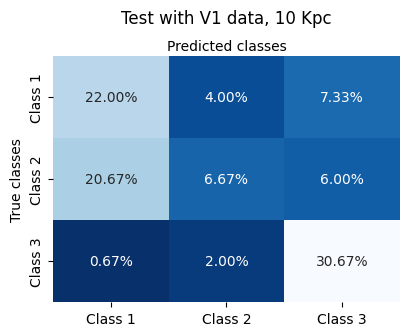

In [ ]:
import seaborn as sns

plt.rcParams["figure.figsize"] = [4.0, 3.0]

fig, ax = plt.subplots()
sns.heatmap(cnf_matrix/np.sum(cnf_matrix), annot = True, cmap = 'Blues_r', fmt='.2%', cbar=False)

ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Test with ' + ifo_conf + ' data, ' + str(distance) + ' Kpc' , y = 1.1)
plt.ylabel('True classes')
plt.xlabel('Predicted classes')

tick_marks = np.arange(0.5, len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#plt.savefig(figs_dir + ifo_conf + "_confu-matrix_test_GRWf_" + str(distance) + "Kpc.pdf", format="pdf")

plt.show()